# import + funcs

In [23]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
import numpy as np
import glob
import json
import os
import pandas as pd
from tqdm import tqdm

def get_avg_log_p(runs_dataset, train=True):
    avg_log_p = []
    std_log_p = []
    params = []
    for run in runs_dataset:
        if train:
            data_key = "train_log_p"
        else:
            data_key = "test_log_p"
        
        sub_run_log_p = []
        params.append(run[0]["params"])
        
        for sub_run in run:
            sub_run_log_p.append(sub_run[data_key].values[:, 0])
            
        sub_run_log_p = np.array(sub_run_log_p)
        
        avg_log_p.append(np.mean(sub_run_log_p, axis=0))
        std_log_p.append(np.std(sub_run_log_p, axis=0))
        
    return avg_log_p, std_log_p, params

def plot_avg_log_p(avg_log_p, std_log_p, params, param_keys=["num_sequence_types", ], plot_size=22, n_std_dev=2):
    f, ax = plt.subplots(36, 4, figsize=(plot_size, plot_size*9))
    ax = ax.flatten()
    for i, log_p in enumerate(avg_log_p):
        
        # Generate legend
        lab = ""
        for key in param_keys:
            lab += key + ": " + str(np.round(params[i][key], 2)) + "\n"
        
        y_err0 = log_p - n_std_dev*std_log_p[i]
        y_err1 = log_p + n_std_dev*std_log_p[i]
        ax[i].fill_between(np.arange(len(log_p)), y_err0, y_err1, alpha=0.5)
        ax[i].plot(log_p, label=lab)
        ax[i].legend()
        
def plot_by_attribute(avg_log_p, std_log_p, params, attr_label="num_sequence_types", attr_val=2, ax=None, xlim=None, ylim=None, n_std_dev=2):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(20, 12))
        
    convergence_avg_p = 0
    valid_comb = 0
    valid_p = []
    for i, log_p in enumerate(avg_log_p):
        
        if params[i][attr_label] == attr_val:
            # Generate legend
            lab = ""
            for key in param_keys:
                lab += key + ": " + str(np.round(params[i][key], 2)) + "\n"

            y_err0 = log_p - n_std_dev*std_log_p[i]
            y_err1 = log_p + n_std_dev*std_log_p[i]
            ax.fill_between(np.arange(len(log_p)), y_err0, y_err1, alpha=0.5)
            ax.plot(log_p)
            ax.set_title(attr_label + ": " + str(attr_val))
            valid_comb += 1
            convergence_avg_p += np.mean(log_p[-10:])
            valid_p.append(log_p)
            
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    convergence_avg_p = convergence_avg_p/valid_comb
    text_x = np.mean(ax.get_xlim())
    text_y = ax.get_ylim()[0] + 0.1*(ax.get_ylim()[1] - ax.get_ylim()[0])
    ax.text(text_x, text_y, "average log p: "+str(np.round(convergence_avg_p, 2)), fontsize=12)
    
    mean_p = np.mean(np.stack(valid_p, axis=0), axis=0)
    
    return mean_p
    
def plot_best(avg_log_p, std_log_p, params, runs_dataset, param_keys=["num_sequence_types", ], n_std_dev=1, plot_n_best=5):

    f, ax = plt.subplots(plot_n_best, 1, figsize=(15, 7*plot_n_best))
    
    log_p_list = []

    for i, log_p in enumerate(avg_log_p):
        convergence_avg_p = np.mean(log_p[-50:])
        log_p_list.append(convergence_avg_p)
    log_p_list = np.array(log_p_list)
    
    ranking = np.argsort(log_p_list)
    ranking = np.flip(ranking)
    
    for rank_id in range(plot_n_best):
        best_id = ranking[rank_id]
        # Generate legend
        lab = ""
        for key in param_keys:
            lab += key + ": " + str(np.round(params[best_id][key], 2)) + "\n"

        y_err0 = avg_log_p[best_id] - n_std_dev*std_log_p[best_id]
        y_err1 = avg_log_p[best_id] + n_std_dev*std_log_p[best_id]

        ax[rank_id].fill_between(np.arange(len(avg_log_p[best_id])), y_err0, y_err1, alpha=0.5)

        runs = runs_dataset[best_id]
        for i, run in enumerate(runs):
            ax[rank_id].plot(run["test_log_p"].values, "C"+str(i+1), lw=4, label=run["run_id"])
            print(run["run_id"])

        ax[rank_id].plot(avg_log_p[best_id], label=lab)
        ax[rank_id].legend(loc="lower right")
        ax[rank_id].set_title("log_p: "+str(log_p_list[best_id]))       


# main

### Get the data from cluster

To get data we need for the hyperparameter search, run the following command with the right path from your local machine in the main directory of the replay repo

`rsync -av --progress rcdavis@ssh.swc.ucl.ac.uk:/nfs/nhome/live/rcdavis/Replay/data/resultsData/ data/resultsData --include *_log_p_hist* --exclude *.csv --exclude trainingData --exclude data_readme*`

In [24]:
#run_list_dirs = glob.glob("../data/resultsData/Coarse_Hyperparameter_Sweep_Thin/*")
#run_list_dirs = glob.glob("../data/resultsData/*")
# run_list_dirs = glob.glob(r"Z:\projects\sequence_squad\revision_data\organised_data\ppseq_data\output_data\HyperSearch\simple_sweeps\*")
list_dirs = glob.glob(r"Z:\projects\sequence_squad\revision_data\organised_data\ppseq_data\output_data\HyperSearch\simple_sweeps\*")
run_list_dirs = []
for path in list_dirs:
    run_list_dirs += [glob.glob(path + '\\*')]
# flatten list
run_list_dirs = [item for sublist in run_list_dirs for item in sublist]


work out percentage run complete for the paramter sweep 

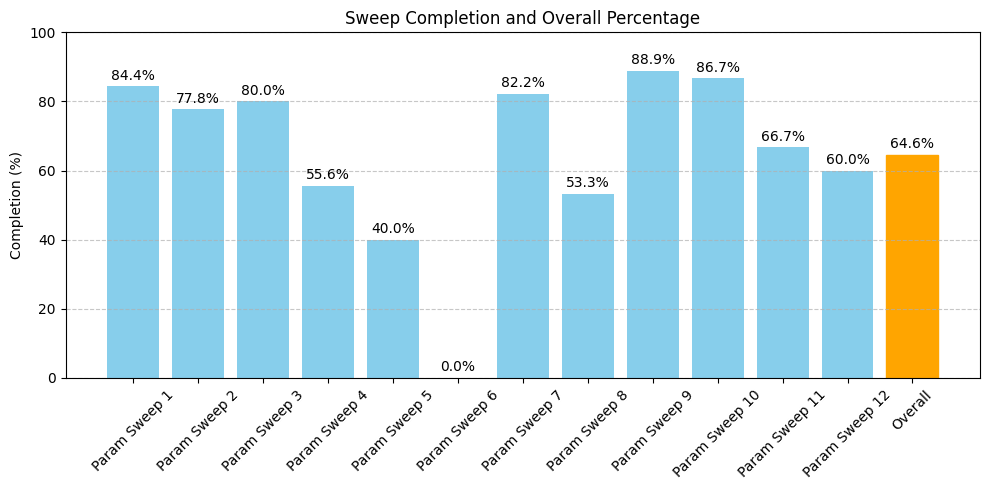

In [25]:
# work out percentage complete of the sweep
all_p_completes  = [[]]*12
for path in list_dirs:
    runs = []
    for file in os.listdir(path):
        if 'grid' in file:
            runs += [int(file.split('_')[2])]
    
    if len(runs) > 0:
        missing = [x for x in range(0, 44) if x not in sorted(runs)]
        prct_complete = (1-len(missing)/45)*100
        all_p_completes[int(path.split('\\')[-1].split('p')[-1])-1] = [prct_complete]
    else:
        all_p_completes[int(path.split('\\')[-1].split('p')[-1])-1] = [0]

# flatten list
all_p_completes = [item for sublist in all_p_completes for item in sublist]



# Compute overall percentage completion
overall = sum(all_p_completes) / len(all_p_completes)

# Labels for the x-axis
labels = [f'Param Sweep {i+1}' for i in range(len(all_p_completes))] + ['Overall']

# Add the overall value to the data
values_with_overall = all_p_completes + [overall]

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values_with_overall, color='skyblue')

# Highlight the overall bar in a different color
bars[-1].set_color('orange')

# Labels and title
plt.ylabel('Completion (%)')
plt.title('Sweep Completion and Overall Percentage')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom')

plt.tight_layout()


load in the data from each run 

In [30]:
runs_dataset = []
for ind in tqdm(range(len(run_list_dirs))):
    run_dir = run_list_dirs[ind]
    
    # Locating directory of each run
    run_id = run_dir.split("\\")[-1]
    
    # added for simple sweeps
    sweep_id = run_dir.split("\\")[-2].split('p')[-1]
    
    # Loading files from each of the runs
    
    if os.path.isfile(os.path.join(run_dir, "config_file.json")) and run_id[0] != 'b':
        params = eval(json.load(open(os.path.join(run_dir, "config_file.json"), "r")))
        test_log_p = pd.read_csv(os.path.join(run_dir, "test_log_p_hist.csv"))
        train_log_p = pd.read_csv(os.path.join(run_dir, "train_log_p_hist.csv"))
        data_dict = {"params": params, "test_log_p": test_log_p, "train_log_p": train_log_p, "run_id": run_id, "sweep_id": sweep_id}

        skip = False
        for i, value in enumerate(runs_dataset):
            if value[0]["params"] == params:
                runs_dataset[i].append(data_dict)
                skip = True
                break

        if not skip:
            runs_dataset.append([data_dict, ])

100%|██████████| 348/348 [07:48<00:00,  1.35s/it]


In [73]:
# for each run, check which params changed compared to the previous
dicts =  [runs[0] for runs in runs_dataset]
changes = []
for i in range(1, len(dicts)):
    prev = dicts[i - 1]['params']
    curr = dicts[i]['params']
    # Compare keys
    changed = [k for k in curr if curr[k] != prev.get(k)]
    if len(changed) == 1:
        changes.append(changed[0])
    else:
        changes.append(changed)  # in case more than one key changes   
# acount for the first run
varied_params = changes + changes[0]  
print(varied_params)

[['seq_event_rate', 'num_sequence_types'], ['seq_event_rate', 'num_sequence_types'], ['seq_event_rate', 'num_sequence_types'], ['seq_event_rate', 'num_sequence_types'], ['seq_event_rate', 'num_sequence_types'], ['seq_event_rate', 'num_sequence_types'], ['seq_event_rate', 'num_sequence_types'], ['seq_event_rate', 'num_sequence_types'], ['seq_event_rate', 'mean_bkgd_spike_rate', 'num_sequence_types'], 'mean_bkgd_spike_rate', 'mean_bkgd_spike_rate', 'mean_bkgd_spike_rate', 'mean_bkgd_spike_rate', 'mean_bkgd_spike_rate', 'mean_bkgd_spike_rate', 'mean_bkgd_spike_rate', ['mean_bkgd_spike_rate', 'var_bkgd_spike_rate'], 'var_bkgd_spike_rate', 'var_bkgd_spike_rate', 'var_bkgd_spike_rate', 'var_bkgd_spike_rate', 'var_bkgd_spike_rate', 'var_bkgd_spike_rate', 'var_bkgd_spike_rate', ['var_bkgd_spike_rate', 'bkgd_spikes_conc_param'], 'bkgd_spikes_conc_param', 'bkgd_spikes_conc_param', 'bkgd_spikes_conc_param', 'bkgd_spikes_conc_param', ['seq_event_rate', 'bkgd_spikes_conc_param'], 'seq_event_rate', 

In [74]:
nruns = []
sweep_group = []
varied_parameters = []
for index,run_group_dict in enumerate(runs_dataset):
    nruns += [len(run_group_dict)]
    sweep_group += [run_group_dict[0]["sweep_id"]]

    # print(run_group_dict[0]["params"]['num_sequence_types'])

    if type(varied_params[index]) == list:
        v_params = []
        for param in varied_params[index]:
            v_params += [(run_group_dict[0]["params"][param])]
        varied_parameters += [v_params]
    else:
        varied_parameters += [[run_group_dict[0]["params"][varied_params[index]]]]
        
    run_group_dict

Text(0.5, 1.0, 'Mean Convergence log p for each parameter sweep')

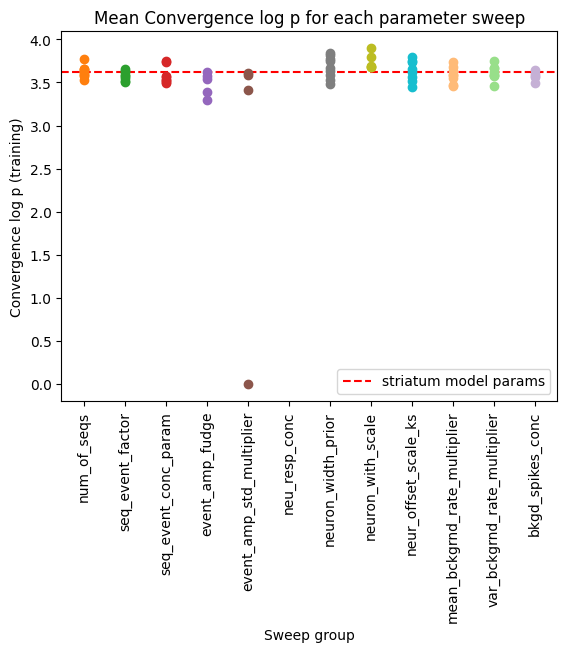

In [75]:
## get averages and std across runs
# avg_log_p, std_log_p, params = get_avg_log_p(runs_dataset, train=False)
avg_log_p, std_log_p, params = get_avg_log_p(runs_dataset, train=True)
num_params = len(avg_log_p)


convergence_log_p= []
for run in avg_log_p:
    convergence_log_p += [np.mean(run[-50::])]
    
#convergence_standard_deviation 
convergence_std = []
for run in std_log_p:
    convergence_std += [np.mean(run[-50::])]
    
    
###### plot oroigional params for a comparison
with open(os.getcwd() + r"\original_params.json", "r") as f:
    origonal_params = json.load(f)
# create empty dict 
original_params_dict = {'convergence_log_p':[],'convergence_std':[], 'sweep_group':[]}
for ind,param_set in enumerate(params):
    if param_set == origonal_params:
        original_params_dict['convergence_log_p'].append(convergence_log_p[ind])
        original_params_dict['convergence_std'].append(convergence_std[ind])
        original_params_dict['sweep_group'].append(sweep_group[ind])

plt.axhline(np.mean(original_params_dict['convergence_log_p']), linestyle = '--', color = 'red', label = 'striatum model params')
plt.legend()
# make 8 colors 
colors = ['#1f77b4', '#ff7f0e', "#2ca02e", '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf','#ffbb78', '#98df8a', '#c5b0d5', '#c49c94', "#54bd17", "#d11ac2"]
params_list = ['num_of_seqs','seq_event_factor','seq_event_conc_param','event_amp_fudge','event_amp_std_multiplier','neu_resp_conc','neuron_width_prior', 'neuron_with_scale','neur_offset_scale_ks' ,'mean_bckgrnd_rate_multiplier', 'var_bckgrnd_rate_multiplier', 'bkgd_spikes_conc']
    
for index,log_p in enumerate(convergence_log_p):
    # plot with error bars with caps 
    # plt.errorbar(int(sweep_group[index]),log_p, yerr=convergence_std[index], fmt='o' , color = colors[int(sweep_group[index])], label = str(varied_parameters[index]), capsize=5) 

    # plt.errorbar(int(sweep_group[index]),log_p, yerr=convergence_std[index], fmt='o' , label = str(varied_parameters[index]), capsize=5)
    plt.plot(int(sweep_group[index]),log_p,'o' , color = colors[int(sweep_group[index])])
plt.xlabel('Sweep group')

# change the x tick names to params list, rotate it 90 degrees
plt.xticks(np.arange(1, len(params_list)+1), params_list, rotation=90)
plt.ylabel('Convergence log p (training)')
plt.title('Mean Convergence log p for each parameter sweep')

In [98]:
# find the best run for each sweep group

best_runs = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]
sweep_group_ints = [int(item) for item in sweep_group]
for ind,param_set in enumerate(params):
    if convergence_log_p[ind] > best_runs[sweep_group_ints[ind]-1]:
        best_runs[sweep_group_ints[ind]-1] = [ind]
    
for i in range(len(best_runs)):
    
    print(f"sweep {i}: {runs_dataset[best_runs[i][0]][0]['run_id']}")

sweep 0: grid_search_25_2705025_0543
sweep 1: grid_search_0_2705025_1307
sweep 2: grid_search_10_1306025_1706
sweep 3: grid_search_0_1905025_1532
sweep 4: grid_search_16_1406025_2218
sweep 5: grid_search_0_1905025_1556
sweep 6: grid_search_0_2405025_0234
sweep 7: grid_search_22_2805025_0448
sweep 8: grid_search_0_0306025_2258
sweep 9: grid_search_0_0506025_1029
sweep 10: grid_search_0_0506025_1937
sweep 11: grid_search_0_1506025_1916


In [89]:
best_runs

[[4], [30], [38], [46], [51], [0], [55], [64], [69], [9], [17], [25]]

'grid_search_25_2705025_0543'

In [56]:
best_runs[12]

IndexError: list index out of range

In [52]:
len(best_runs)

12

In [40]:
min([int(item) for item in sweep_group])

1

In [32]:
original_params_dict

{'convergence_log_p': [3.61483606036043],
 'convergence_std': [0.14520992205154662],
 'sweep_group': ['1']}

In [ ]:
# find the highest log p for each param...
# then i will make these plots

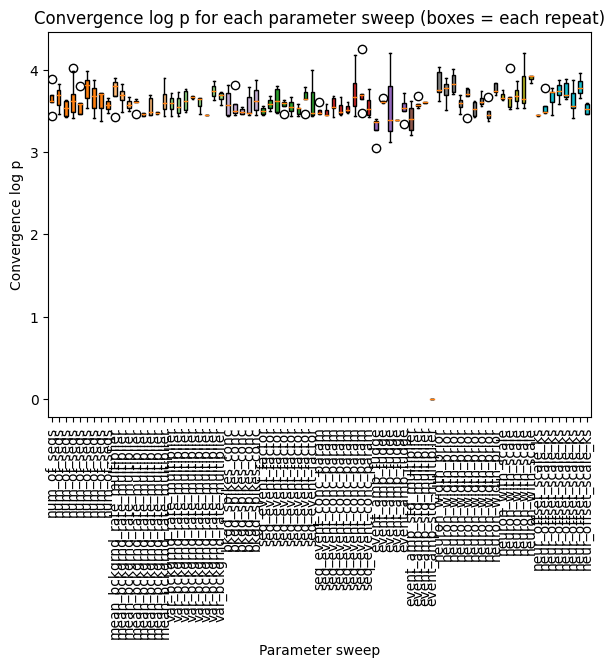

In [69]:
all_c_log_ps = []
for run_set in runs_dataset:
    convergence_log_p = []
    for run in run_set:
        #convergence log p 
        convergence_log_p += [np.mean(run['train_log_p'][-50::])]
    all_c_log_ps += [convergence_log_p]


# plot a box plot of each of the convergence log p, add a facecolor 
plt.figure(figsize=(7, 5))
plt.title("Convergence log p for each parameter sweep (boxes = each repeat)")
plt.ylabel("Convergence log p")
plt.xlabel("Parameter sweep")
box = plt.boxplot(all_c_log_ps, labels=[params_list[int(item)-1] for item in sweep_group],patch_artist=True)
plt.xticks(rotation=90)


# Apply colors to boxes
for patch, color in zip(box['boxes'], [colors[int(item)] for item in sweep_group]):
    patch.set_facecolor(color)


In [72]:
convergence_log_p

[3.4583389297475158, 3.592183500036109, 3.580475659101641, 3.46128702767228]

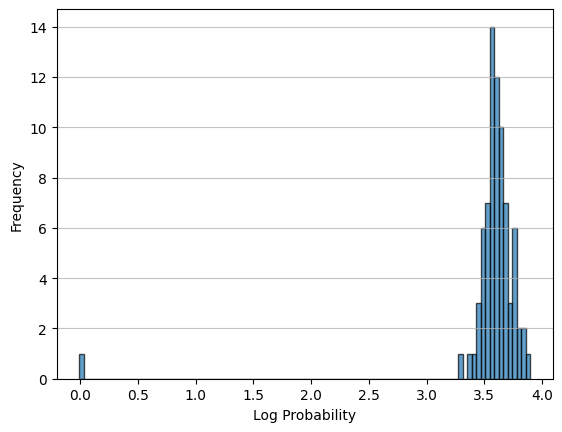

In [76]:


plt.hist(convergence_log_p, bins=100, edgecolor='black', alpha=0.7, color=colors[0])
plt.xlabel('Log Probability')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

grid_search_42_0105025_0826
grid_search_43_0105025_1401
grid_search_44_0105025_1036
grid_search_41_3004025_1955
grid_search_42_3004025_2229
grid_search_43_3004025_2254
grid_search_30_3004025_1532
grid_search_32_0105025_0004
grid_search_33_3004025_1606
grid_search_31_3004025_1848
grid_search_32_3004025_1926
grid_search_33_3004025_2227
grid_search_34_0105025_0026
grid_search_26_0505025_1014
grid_search_27_0405025_1441
grid_search_35_0105025_0753
grid_search_36_0105025_0715
grid_search_37_0105025_0705
grid_search_38_0105025_0726
grid_search_39_0105025_0849
grid_search_36_3004025_1736
grid_search_37_3004025_1754
grid_search_38_3004025_1635
grid_search_39_3004025_1723
grid_search_5_3004025_1802
grid_search_6_3004025_1742
grid_search_7_3004025_1908
grid_search_8_3004025_1651
grid_search_15_3004025_1650
grid_search_16_3004025_2055
grid_search_17_3004025_1537
grid_search_18_3004025_1542
grid_search_19_3004025_1631
grid_search_10_3004025_2257
grid_search_11_3004025_2259
grid_search_13_0105025_0

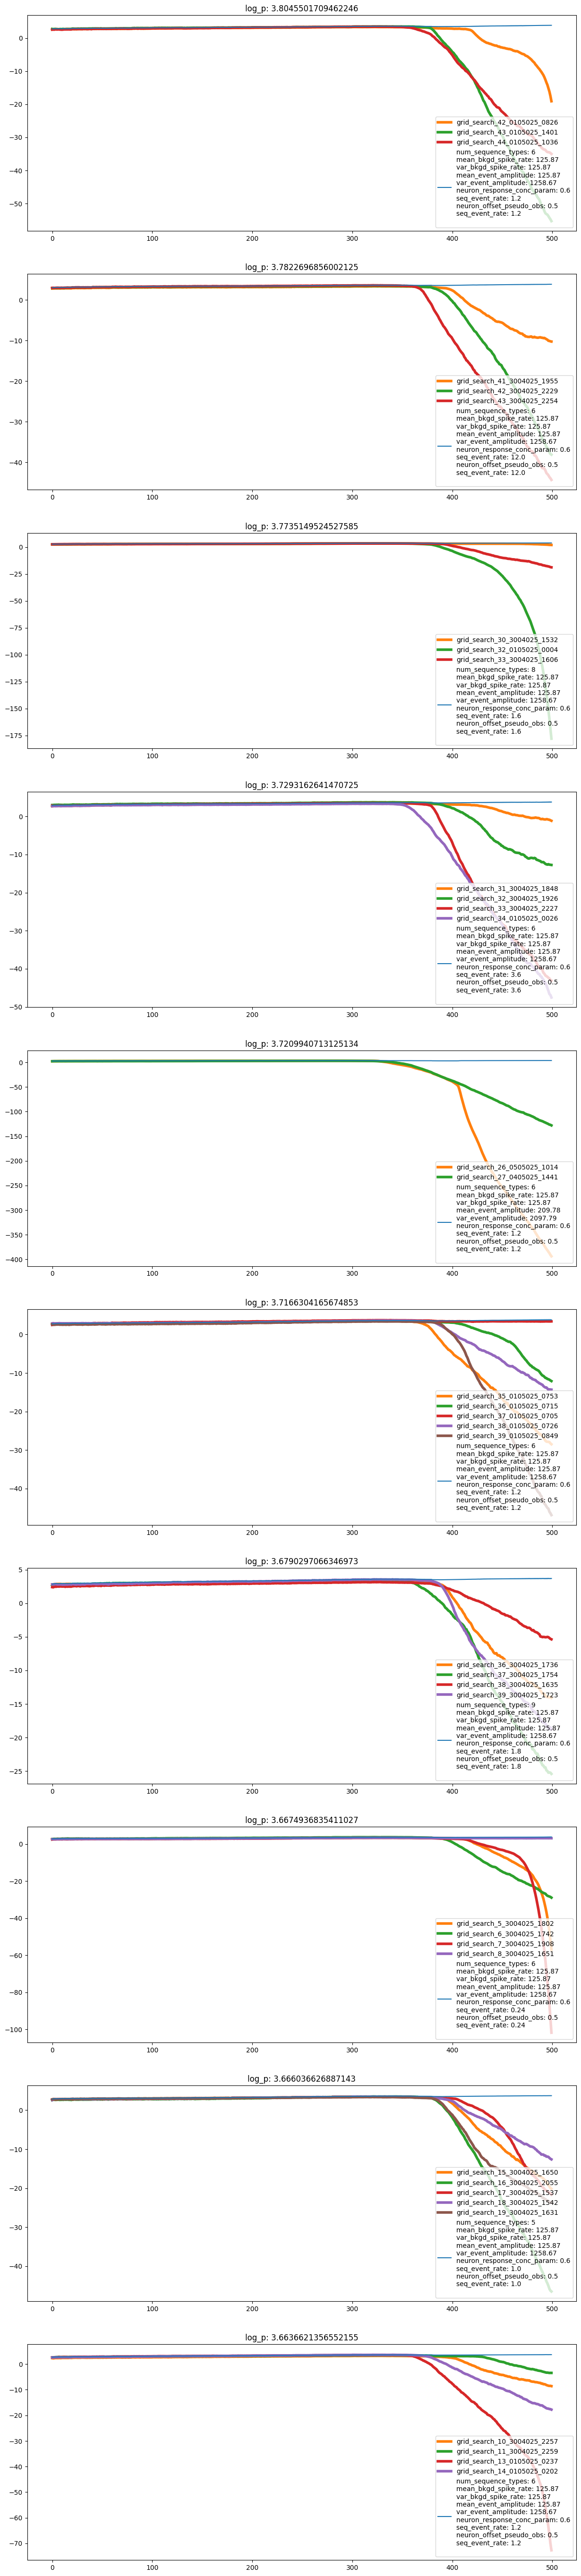

In [250]:
param_keys = ["num_sequence_types", "mean_bkgd_spike_rate", "var_bkgd_spike_rate", "mean_event_amplitude", 
              "var_event_amplitude", "neuron_response_conc_param", "seq_event_rate", "neuron_offset_pseudo_obs", "seq_event_rate"]

plot_best(avg_log_p, std_log_p, params,runs_dataset, param_keys, plot_n_best = 10)

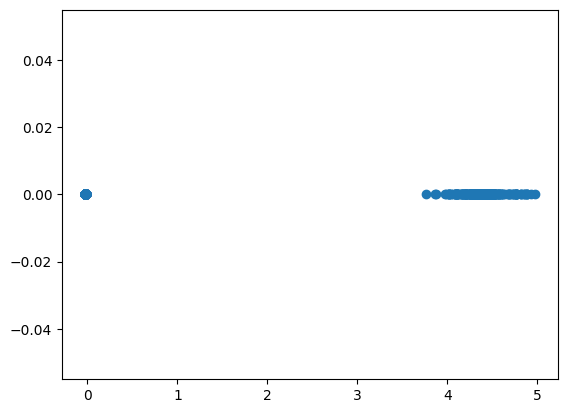

In [129]:
plt.plot(convergence_log_p,np.zeros(len(convergence_log_p)), 'o')

In [ ]:
log_p_per_param = np.zeros([num_params])
std_log_p_per_param = np.zeros([num_params])
for i, log_p in enumerate(avg_log_p):
    log_p_per_param[i]  = np.mean(log_p[-50:])
    std_log_p_per_param[i] = np.mean(std_log_p[i][-50:])
    sorted_indices = np.flip(np.argsort(log_p_per_param))
    
keys_to_print = {"num_sequence_types", "mean_bkgd_spike_rate", "var_bkgd_spike_rate", "mean_event_amplitude", 
              "var_event_amplitude", "neuron_response_conc_param", "seq_event_rate", "neuron_offset_pseudo_obs", "seq_event_rate"}

for i in range(10):
    print('Mean log L: \t \t', log_p_per_param[sorted_indices[i]])
    print('Error Bar L: \t \t', std_log_p_per_param[sorted_indices[i]])
    for key in keys_to_print:
        print(key, '\t \t', runs_dataset[sorted_indices[i]][0]['params'][key])
    #print(runs_dataset[sorted_indices[i]])
    print()

Mean log L: 	 	 4.977863765861608
Error Bar L: 	 	 0.0
seq_event_rate 	 	 30.0
var_event_amplitude 	 	 476.8628333333334
mean_event_amplitude 	 	 47.68628333333334
var_bkgd_spike_rate 	 	 143.05885
num_sequence_types 	 	 3
mean_bkgd_spike_rate 	 	 143.05885
neuron_offset_pseudo_obs 	 	 10.0
neuron_response_conc_param 	 	 0.6

Mean log L: 	 	 4.923376224243741
Error Bar L: 	 	 0.0
seq_event_rate 	 	 30.0
var_event_amplitude 	 	 238.4314166666667
mean_event_amplitude 	 	 23.84314166666667
var_bkgd_spike_rate 	 	 143.05885
num_sequence_types 	 	 3
mean_bkgd_spike_rate 	 	 143.05885
neuron_offset_pseudo_obs 	 	 1.0
neuron_response_conc_param 	 	 0.6

Mean log L: 	 	 4.88351036771046
Error Bar L: 	 	 0.0
seq_event_rate 	 	 30.0
var_event_amplitude 	 	 476.8628333333334
mean_event_amplitude 	 	 47.68628333333334
var_bkgd_spike_rate 	 	 143.05885
num_sequence_types 	 	 3
mean_bkgd_spike_rate 	 	 143.05885
neuron_offset_pseudo_obs 	 	 0.5
neuron_response_conc_param 	 	 0.1

Mean log L: 	 	 4.8

In [12]:
get_keys_unique = ["num_sequence_types", "mean_bkgd_spike_rate", "var_bkgd_spike_rate", "mean_event_amplitude", 
              "var_event_amplitude", "neuron_response_conc_param", "seq_event_rate", "neuron_offset_pseudo_obs", "seq_event_rate"]
key_unique_values = {}

for key in get_keys_unique:
    param_list = []
    for p in params:
        param_list.append(p[key])
    key_unique_values[key] = np.unique(param_list)

In [13]:
key_unique_values["mean_event_amplitude"]

array([  23.84314167,   47.68628333, 2384.31416667, 4768.62833333])

In [14]:
def get_run_params(slurm_id):
    num_of_seqs = [4, 5, 6, 7]
    fudges = [0.05, 0.1, 0.3, 1.0]
    phis = [0.6, 1.0, 1.6, 3.0]
    ks = [0.5, 1.0, 5.0, 10.0]
    seq_event_factor = [0.1, 0.5, 1.0, 5.0]
    k_index = int(slurm_id%len(ks))
    index_leftover = (slurm_id - k_index)/len(ks)
    phi_index = np.rint(index_leftover%len(phis)).astype(int)
    index_leftover = (index_leftover - phi_index)/len(phis)
    fudge_index = np.rint(index_leftover%len(fudges)).astype(int)
    index_leftover = (index_leftover - fudge_index)/len(fudges)
    seq_index = np.rint(index_leftover%len(num_of_seqs)).astype(int)
    index_leftover = (index_leftover - seq_index)/len(num_of_seqs)
    seq_event_index = int(index_leftover%len(seq_event_factor))
    
    # print(k_index, phi_index, fudge_index, seq_index, seq_event_index)
    
    return num_of_seqs[seq_index], fudges[fudge_index], phis[phi_index], ks[k_index], seq_event_factor[seq_event_index]


for i in range(1024):
    print("num_of_seqs,", "fudges,", "phis,", "ks,", "seq_event_factor")
    print(get_run_params(i))


num_of_seqs, fudges, phis, ks, seq_event_factor
(4, 0.05, 0.6, 0.5, 0.1)
num_of_seqs, fudges, phis, ks, seq_event_factor
(4, 0.05, 0.6, 1.0, 0.1)
num_of_seqs, fudges, phis, ks, seq_event_factor
(4, 0.05, 0.6, 5.0, 0.1)
num_of_seqs, fudges, phis, ks, seq_event_factor
(4, 0.05, 0.6, 10.0, 0.1)
num_of_seqs, fudges, phis, ks, seq_event_factor
(4, 0.05, 1.0, 0.5, 0.1)
num_of_seqs, fudges, phis, ks, seq_event_factor
(4, 0.05, 1.0, 1.0, 0.1)
num_of_seqs, fudges, phis, ks, seq_event_factor
(4, 0.05, 1.0, 5.0, 0.1)
num_of_seqs, fudges, phis, ks, seq_event_factor
(4, 0.05, 1.0, 10.0, 0.1)
num_of_seqs, fudges, phis, ks, seq_event_factor
(4, 0.05, 1.6, 0.5, 0.1)
num_of_seqs, fudges, phis, ks, seq_event_factor
(4, 0.05, 1.6, 1.0, 0.1)
num_of_seqs, fudges, phis, ks, seq_event_factor
(4, 0.05, 1.6, 5.0, 0.1)
num_of_seqs, fudges, phis, ks, seq_event_factor
(4, 0.05, 1.6, 10.0, 0.1)
num_of_seqs, fudges, phis, ks, seq_event_factor
(4, 0.05, 3.0, 0.5, 0.1)
num_of_seqs, fudges, phis, ks, seq_event_factor


In [25]:
run_indexes = []
for data_dict_list in runs_dataset:
    for data_dict in data_dict_list:
        slurm_id = int(data_dict["run_id"].split("_")[-3])
        run_indexes.append(slurm_id)
        # break

In [26]:
param_runs = pd.DataFrame(columns=["num_of_seqs", "fudges", "phis", "ks", "seq_event_factor"])
for i, run_index in enumerate(run_indexes):
    param_runs.loc[i] = get_run_params(run_index)

array([[<Axes: title={'center': 'num_of_seqs'}>,
        <Axes: title={'center': 'fudges'}>],
       [<Axes: title={'center': 'phis'}>, <Axes: title={'center': 'ks'}>],
       [<Axes: title={'center': 'seq_event_factor'}>, <Axes: >]],
      dtype=object)

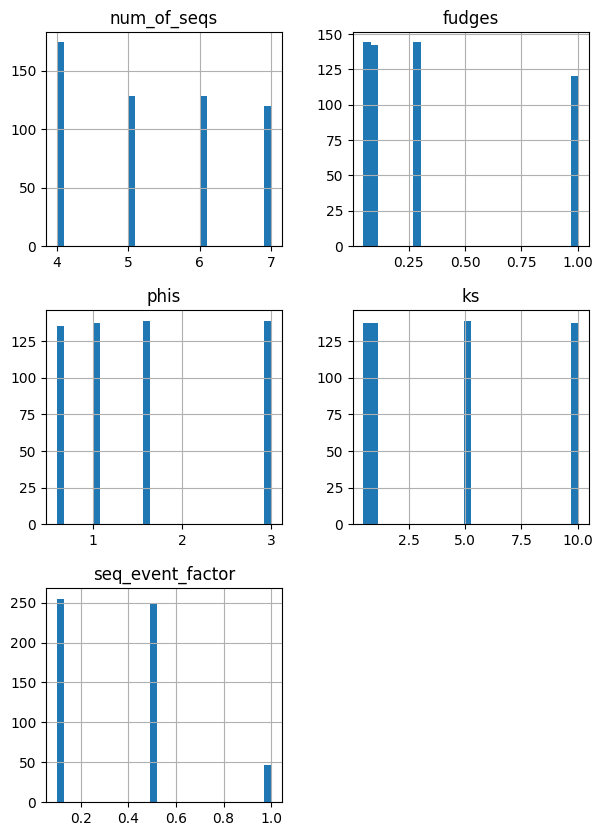

In [27]:
param_runs.hist(figsize=(7, 10), bins=30)

In [28]:
np.unique(param_runs["fudges"], return_counts=True)

(array([0.05, 0.1 , 0.3 , 1.  ]), array([144, 142, 144, 120], dtype=int64))

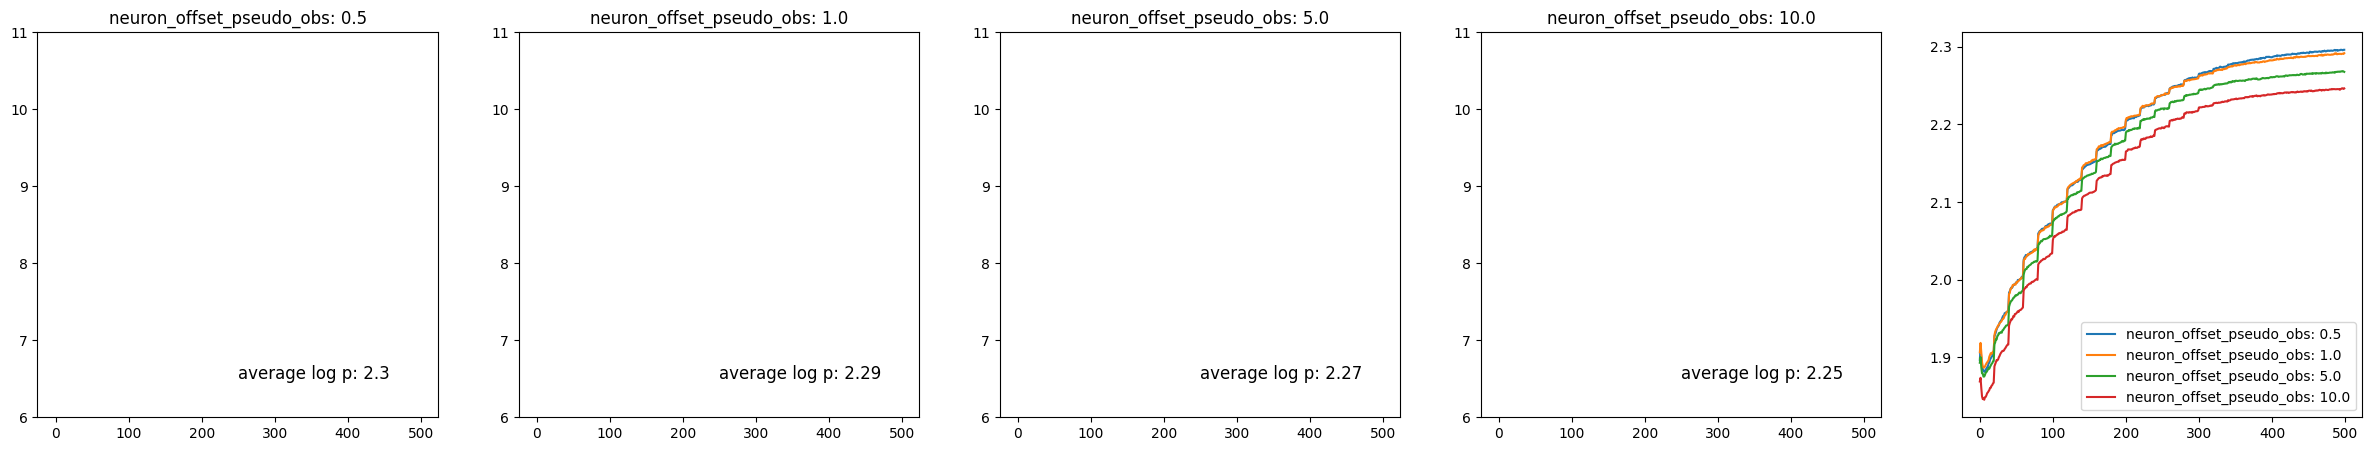

In [29]:
plot_key = "neuron_offset_pseudo_obs"
list_vals = key_unique_values[plot_key]
f, ax = plt.subplots(1, len(list_vals)+1, figsize=(6*(len(list_vals)+1), 5))
ylim = (6, 11)
for i, num_seq in enumerate(list_vals):
    mean_p = plot_by_attribute(avg_log_p, std_log_p, params, ax=ax[i], attr_label=plot_key, attr_val=num_seq, ylim=ylim, n_std_dev=1)
    ax[-1].plot(mean_p, label=plot_key+": "+str(np.round(num_seq, 2)))
ax[-1].legend()

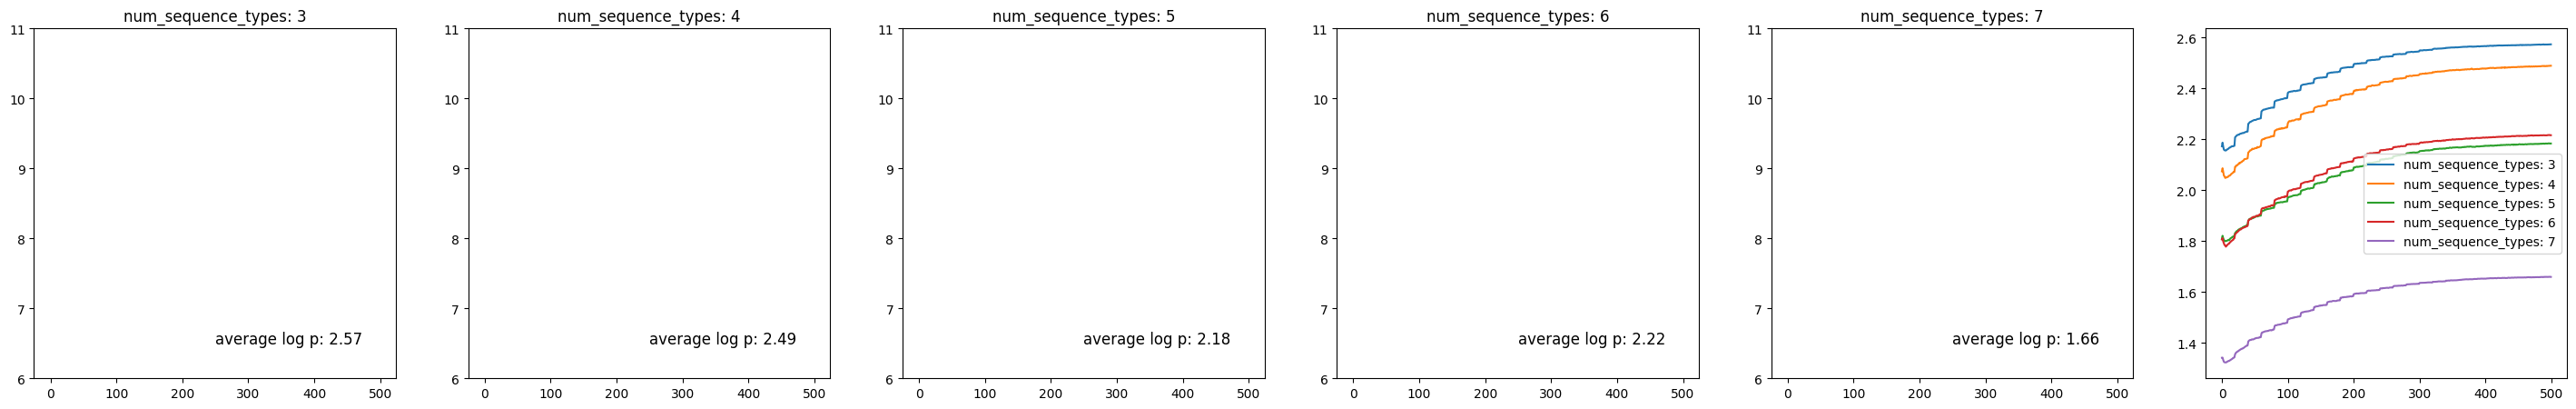

In [30]:
plot_key = "num_sequence_types"
list_vals = key_unique_values[plot_key]
f, ax = plt.subplots(1, len(list_vals)+1, figsize=(6*(len(list_vals)+1), 5))
ylim = (6, 11)
for i, num_seq in enumerate(list_vals):
    mean_p = plot_by_attribute(avg_log_p, std_log_p, params, ax=ax[i], attr_label=plot_key, attr_val=num_seq, ylim=ylim, n_std_dev=1)
    ax[-1].plot(mean_p, label=plot_key+": "+str(np.round(num_seq, 2)))
ax[-1].legend()

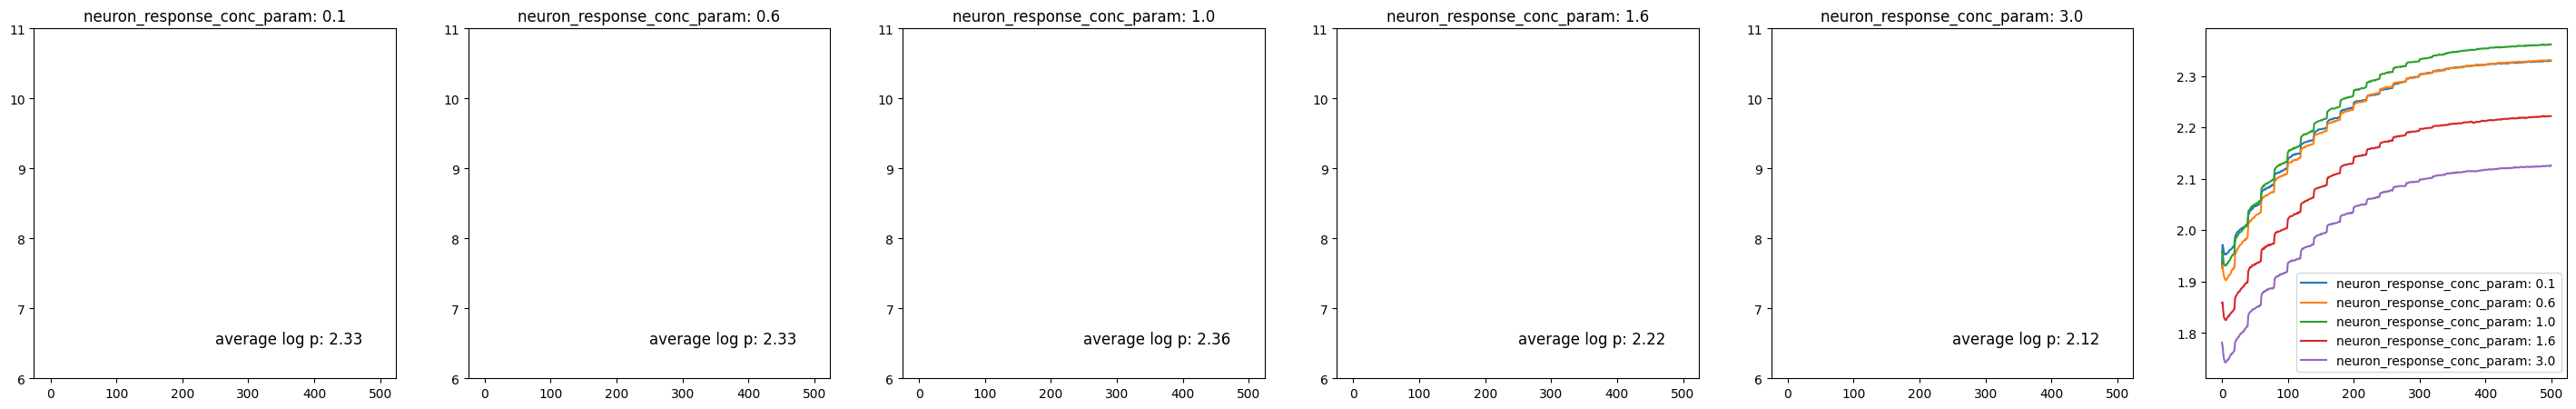

In [31]:
plot_key = "neuron_response_conc_param"
list_vals = key_unique_values[plot_key]
f, ax = plt.subplots(1, len(list_vals)+1, figsize=(6*(len(list_vals)+1), 5))
ylim = (6, 11)
for i, num_seq in enumerate(list_vals):
    mean_p = plot_by_attribute(avg_log_p, std_log_p, params, ax=ax[i], attr_label=plot_key, attr_val=num_seq, ylim=ylim, n_std_dev=1)
    ax[-1].plot(mean_p, label=plot_key+": "+str(np.round(num_seq, 2)))
ax[-1].legend()

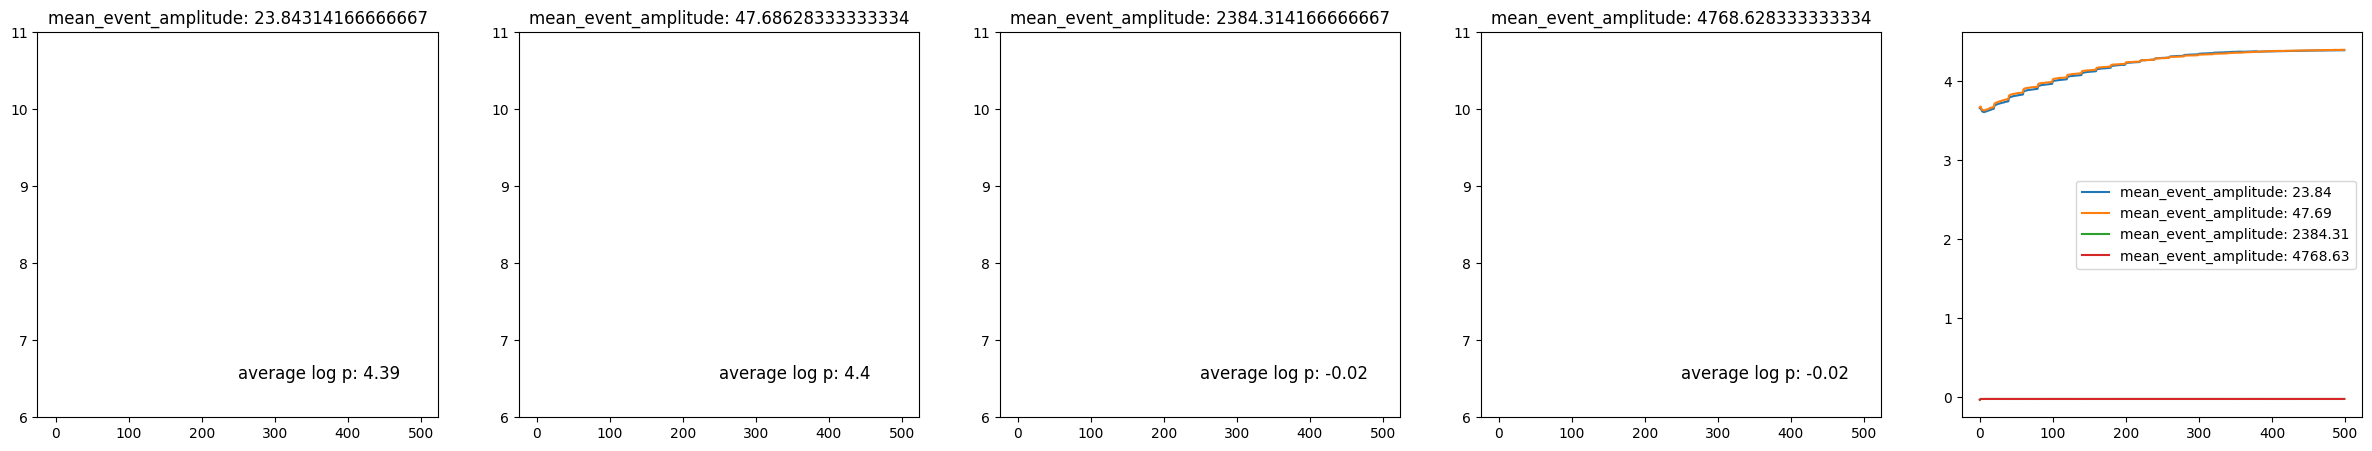

In [32]:
plot_key = "mean_event_amplitude"
list_vals = key_unique_values[plot_key]
f, ax = plt.subplots(1, len(list_vals)+1, figsize=(6*(len(list_vals)+1), 5))
ylim = (6, 11)
for i, num_seq in enumerate(list_vals):
    mean_p = plot_by_attribute(avg_log_p, std_log_p, params, ax=ax[i], attr_label=plot_key, attr_val=num_seq, ylim=ylim, n_std_dev=1)
    ax[-1].plot(mean_p, label=plot_key+": "+str(np.round(num_seq, 2)))
ax[-1].legend()

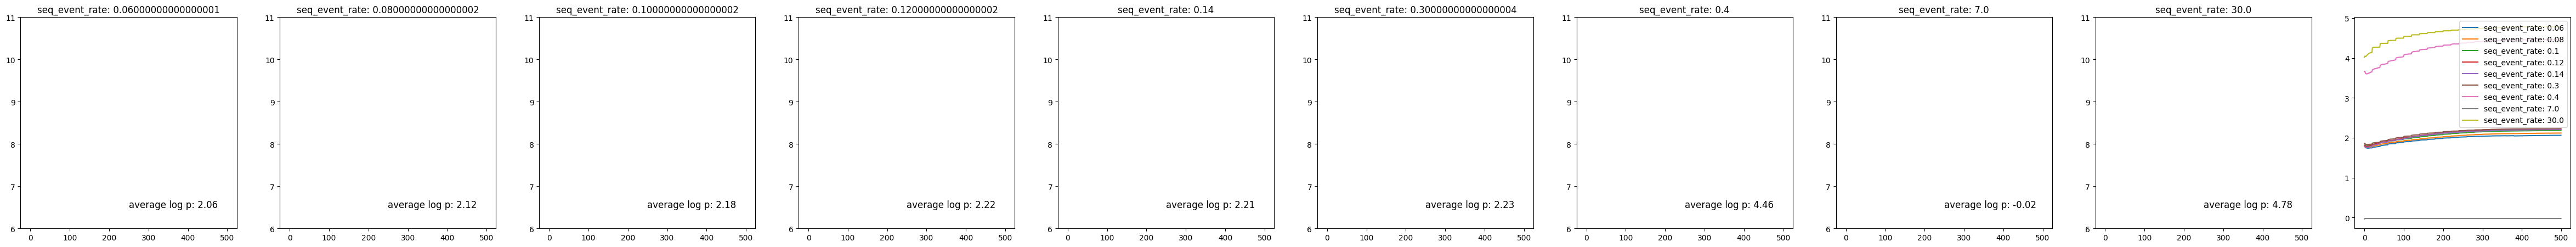

In [33]:
plot_key = "seq_event_rate"
list_vals = key_unique_values[plot_key]
f, ax = plt.subplots(1, len(list_vals)+1, figsize=(6*(len(list_vals)+1), 5))
ylim = (6, 11)
for i, num_seq in enumerate(list_vals):
    mean_p = plot_by_attribute(avg_log_p, std_log_p, params, ax=ax[i], attr_label=plot_key, attr_val=num_seq, ylim=ylim, n_std_dev=1)
    ax[-1].plot(mean_p, label=plot_key+": "+str(np.round(num_seq, 2)))
ax[-1].legend()

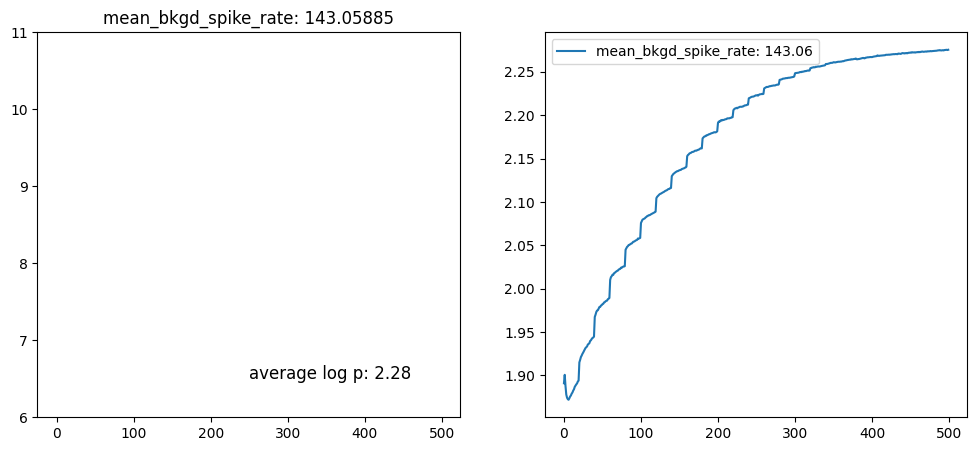

In [34]:
plot_key = "mean_bkgd_spike_rate"
list_vals = key_unique_values[plot_key]
f, ax = plt.subplots(1, len(list_vals)+1, figsize=(6*(len(list_vals)+1), 5))
ylim = (6, 11)
for i, num_seq in enumerate(list_vals):
    mean_p = plot_by_attribute(avg_log_p, std_log_p, params, ax=ax[i], attr_label=plot_key, attr_val=num_seq, ylim=ylim, n_std_dev=1)
    ax[-1].plot(mean_p, label=plot_key+": "+str(np.round(num_seq, 2)))
ax[-1].legend()

IndexError: index 144 is out of bounds for axis 0 with size 144

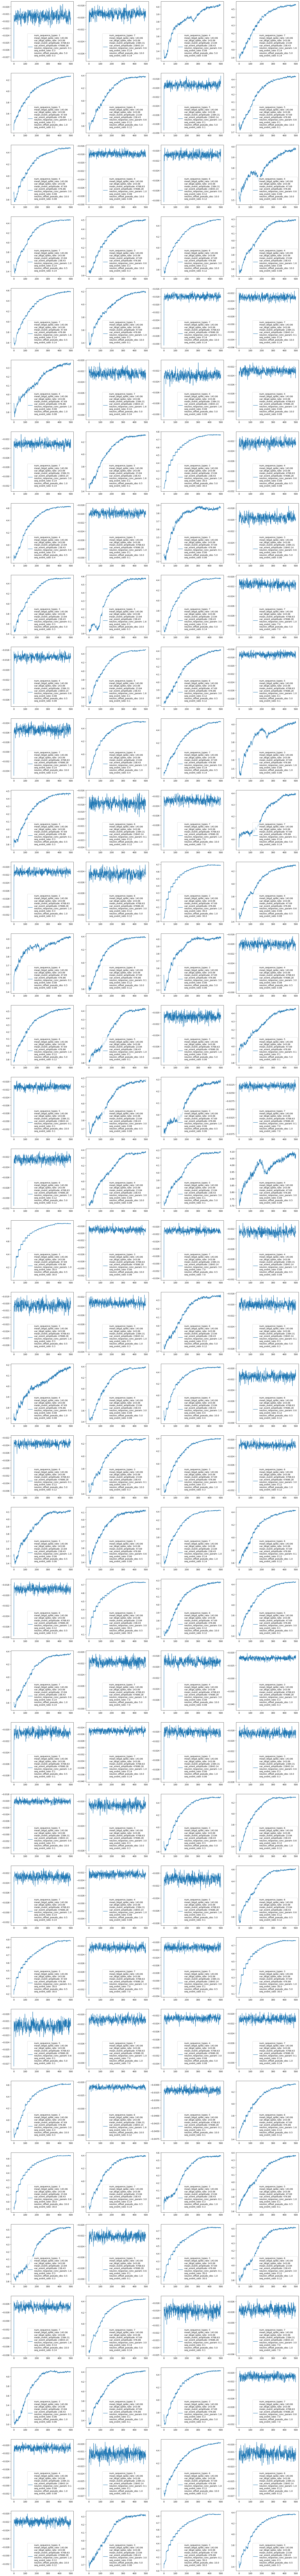

In [35]:
plot_avg_log_p(avg_log_p, std_log_p, params, param_keys, plot_size=24, n_std_dev=1)